In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../code/gwas_analysis')
from gwas_plotting import manhattan, manhattan_fixwidth, qqplot

from matplotlib import rcParams, font_manager
from scipy.stats import chi2

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
import os
import statsmodels.stats.multitest as sm

In [4]:
genes = ['A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1', 'DRB1']
genes

['A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1', 'DQB1', 'DRB1']

In [38]:
cmd_base = "source activate RSAIGE\n"
cmd_base += "Rscript /home/sraju/SAIGE_Git/extdata/step2_SPAtests.R        \
        --vcfFile={infn}  \
        --vcfFileIndex={infn}.csi    \
        --vcfField=DS   \
        --AlleleOrder=ref-first \
        --SAIGEOutputFile={outfn} \
        --chrom=6       \
        --minMAF=0 \
        --minMAC=20 \
        --GMMATmodelFile=/home/sraju/{rdir}/{p}/results/raw_gwas/SAIGE.rda \
        --varianceRatioFile=/home/sraju/{rdir}/{p}/results/raw_gwas/SAIGE.varianceRatio.txt   \
        --LOCO=TRUE \
        --is_Firth_beta=TRUE       \
        --pCutoffforFirth=0.01       \
        --is_output_moreDetails=TRUE"
print(cmd_base)

source activate RSAIGE
Rscript /home/sraju/SAIGE_Git/extdata/step2_SPAtests.R                --vcfFile={infn}          --vcfFileIndex={infn}.csi            --vcfField=DS           --AlleleOrder=ref-first         --SAIGEOutputFile={outfn}         --chrom=6               --minMAF=0         --minMAC=20         --GMMATmodelFile=/home/sraju/{rdir}/{p}/results/raw_gwas/SAIGE.rda         --varianceRatioFile=/home/sraju/{rdir}/{p}/results/raw_gwas/SAIGE.varianceRatio.txt           --LOCO=TRUE         --is_Firth_beta=TRUE               --pCutoffforFirth=0.01               --is_output_moreDetails=TRUE


In [26]:
ncores = 7
resdirmap = {'MergeEpoch_NG_Died_vs_Survived':'outcome_H3covar_20220315',
         'MergeEpoch_SL_Died_vs_Survived':'outcome_H3covar_20220315',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':'results_20220311',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':'results_20220311'}

In [33]:
vcfcols = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT']

header = """##fileformat=VCFv4.3
##fileDate=20230823
##source=PLINKv2.00
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=17,length=81195210>
##pbwtVersion=3.1-v3.1-2-gbf6ebe2+htslib-1.3.2-199-gec1d68e-dirty
##pbwtCommand=pbwt -log dacceb7706d8cd40f3d5f3ecff0dd56e.pbwt/0/7/0.17.bcf.log -
##INFO=<ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes">
##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in call
##INFO=<ID=RefPanelAF,Number=A,Type=Float,Description="Allele frequency in imput
##INFO=<ID=TYPED,Number=0,Type=Flag,Description="Site was genotyped prior to imp
##bcftools_mergeVersion=1.9+htslib-1.9
##bcftools_mergeCommand=merge -l dacceb7706d8cd40f3d5f3ecff0dd56e.pbwt/merged/8/
##bcftools_annotateVersion=1.9+htslib-1.9
##bcftools_annotateCommand=annotate -Ou -x INFO/DR2; Date=Thu Feb 24 18:41:11 20
##INFO=<ID=INFO,Number=1,Type=Float,Description="IMPUTE2 info score">
##bcftools_pluginVersion=1.9+htslib-1.9
##bcftools_pluginCommand=plugin impute-info -Ou; Date=Thu Feb 24 18:41:11 2022
##bcftools_annotateCommand=annotate -Ou -c CHROM,POS,ID,REF,ALT -a resources/dbs
##FORMAT=<ID=DS,Number=A,Type=Float,Description="Estimated Alternate Allele Dosage"
"""

In [52]:
for gene in genes:
    print(gene)
    curr_df = pd.read_csv('/home/sraju/HIBAG_sandbox/outputs/' + gene + '_dosages.txt', sep = '\t', index_col = 0)
    for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    
        famfn = '/home/sraju/{rdir}/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam'.format(p=p, rdir=resdirmap[p])
        samporder = pd.read_csv(famfn, sep='\t', header=None)[1]    

        hlainfo = curr_df.loc[:, samporder]

        hlainfo['#CHROM'] = '6'
        hlainfo['POS'] = '1'
        hlainfo['ID'] = list(curr_df.index) # the allele name
        hlainfo['REF'] = 'A'
        hlainfo['ALT'] = 'G'
        hlainfo['QUAL'] = '.'
        hlainfo['FILTER'] = 'PASS'
        hlainfo['INFO'] = '.'
        hlainfo['FORMAT'] = 'DS'
    
        hlainfo = hlainfo.loc[:, vcfcols +list(samporder)]    
        hlafn = os.path.join(os.path.dirname(famfn), '../' + gene + '_hla_dosage_forSAIGE.vcf').format(p=p)
    
        with open(hlafn, 'w') as F:
            F.write(header)
    
        hlainfo.to_csv(hlafn, sep='\t', index=False, mode='a')
        outfn =  hlafn.replace('.vcf', '.results.tsv')

        cmd = 'bgzip -c {fn} > {fn}.gz'.format(fn=hlafn)
        #print(cmd)
        !{cmd}
    
        cmd = 'tabix --csi -p vcf %s.gz' % hlafn
        #print(cmd)
        !{cmd}    
    
    
        cmd = cmd_base.format(infn=hlafn+'.gz', outfn=outfn, rdir=resdirmap[p], p=p)
        print(cmd)
        !{cmd}
        print('\n\n')

A
source activate RSAIGE
Rscript /home/sraju/SAIGE_Git/extdata/step2_SPAtests.R                --vcfFile=/home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/../A_hla_dosage_forSAIGE.vcf.gz          --vcfFileIndex=/home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/../A_hla_dosage_forSAIGE.vcf.gz.csi            --vcfField=DS           --AlleleOrder=ref-first         --SAIGEOutputFile=/home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/raw_data/../A_hla_dosage_forSAIGE.results.tsv         --chrom=6               --minMAF=0         --minMAC=20         --GMMATmodelFile=/home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE.rda         --varianceRatioFile=/home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/results/raw_gwas/SAIGE.varianceRatio.txt           --LOCO=TRUE         --is_Firth_beta=TRUE               --pCutoffforFirth=0.01               --is_output_moreDetails=TRUE

In [80]:
res_all = {}
for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    res_pheno = {}
    for gene in genes:
        curr_df = pd.read_csv('/home/sraju/HIBAG_sandbox/outputs/' + gene + '_dosages.txt', sep = '\t', index_col = 0)
        famfn = '/home/sraju/{rdir}/{p}/raw_data/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220223.deduped.{p}.maf_1e-2.hwe_1e-6.geno_5e-2.FixSexChr.fam'.format(p=p, rdir=resdirmap[p])    
        hlafn = os.path.join(os.path.dirname(famfn), '../' + gene + '_hla_dosage_forSAIGE.vcf').format(p=p)
        outfn =  hlafn.replace('.vcf', '.results.tsv')

        res = pd.read_csv(outfn, sep='\t')
        res['MarkerID'] = res['MarkerID'] + gene
        res.index = res['MarkerID']
        res['gene'] = gene
        res['N'] = res['N_case'] + res['N_ctrl']
        res_pheno[gene] = res
    res_all[p] = res_pheno

In [81]:
res_all['MergeEpoch_SL_Died_vs_Survived']['A']

,CHR,POS,MarkerID,Allele1,Allele2,AC_Allele2,AF_Allele2,MissingRate,BETA,SE,...,AF_case,AF_ctrl,N_case,N_ctrl,N_case_hom,N_case_het,N_ctrl_hom,N_ctrl_het,gene,N
MarkerID,,,,,,,,,,,,,,,,,,,,,
23:01A,6,1,23:01A,A,G,35.7732,0.165616,0,-0.485616,0.474548,...,0.164866,0.167000,70,38,1,23,1,11,A,108
02:01A,6,1,02:01A,A,G,37.7398,0.174721,0,-0.139989,0.426329,...,0.148094,0.223771,70,38,5,11,1,15,A,108


In [82]:
# make a function which outputs the pval histogram, qval table, min qval table
def make_hla_assoc_outputs(res, output_directory):
    
    # pval histogram
    all_res = pd.concat(res.values(), ignore_index=True) 
    all_res.to_csv(output_directory + "combined_HLAs.tsv", sep = '\t', index = False)
    (fig,ax) = plt.subplots(1,1)
    plt.hist(all_res['p.value'])
    ax.set_xlabel('PVAL')
    ax.set_title('PVAL Histogram')
    plt.savefig(output_directory + "pvalhist.png",
               bbox_inches = 'tight')
    
    # qval table
    qval_input = all_res[['MarkerID', 'gene', 'p.value']].dropna(axis=0)
    qval_input['qval'] = sm.fdrcorrection(qval_input['p.value'], alpha = 0.05)[1]
    qval_input = qval_input.reset_index()
    qval_input.to_csv(output_directory + "qvals.tsv", sep = '\t')
    
    # min qval table
    print(qval_input)
    qval_final = qval_input.loc[qval_input.groupby('gene')['qval'].idxmin()][['gene', 'qval', 'MarkerID']]
    print(qval_final)
    qval_final.to_csv(output_directory + "qval_min.tsv", sep = '\t')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

    index   MarkerID  gene   p.value      qval
0       0     34:02A     A  0.731428  0.940138
1       1     36:01A     A  0.367203  0.788415
2       2     23:01A     A  0.094868  0.788415
3       3     02:02A     A  0.956819  0.980150
4       4     30:02A     A  0.563731  0.921427
..    ...        ...   ...       ...       ...
66     66  08:04DRB1  DRB1  0.782302  0.940138
67     67  01:02DRB1  DRB1  0.974338  0.980150
68     68  07:01DRB1  DRB1  0.932001  0.980150
69     69  11:01DRB1  DRB1  0.032952  0.741010
70     70  12:01DRB1  DRB1  0.624844  0.924249

[71 rows x 5 columns]
    gene      qval   MarkerID
1      A  0.788415     36:01A
13     B  0.741010     57:03B
22     C  0.788415     04:01C
34  DPA1  0.788415  02:01DPA1
40  DPB1  0.663026  13:01DPB1
44  DQA1  0.788415  01:02DQA1
53  DQB1  0.788415  05:02DQB1
69  DRB1  0.741010  11:01DRB1


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

    index   MarkerID  gene   p.value      qval
0       0     23:01A     A  0.306155  0.640143
1       1     02:01A     A  0.742640  0.853971
2       2     35:01B     B  0.798847  0.853971
3       3     53:01B     B  0.080190  0.519183
4       4     04:01C     C  0.276768  0.636568
5       5     17:01C     C  0.090293  0.519183
6       6     16:01C     C  0.480072  0.788690
7       7  01:03DPA1  DPA1  0.550498  0.844096
8       8  02:01DPA1  DPA1  0.962620  0.962620
9       9  03:01DPA1  DPA1  0.136209  0.622513
10     10  02:02DPA1  DPA1  0.478733  0.788690
11     11  01:01DPB1  DPB1  0.790833  0.853971
12     12  01:02DQA1  DQA1  0.658926  0.853971
13     13  04:01DQA1  DQA1  0.816842  0.853971
14     14  01:01DQA1  DQA1  0.226208  0.636568
15     15  05:05DQA1  DQA1  0.073178  0.519183
16     16  03:03DQA1  DQA1  0.259180  0.636568
17     17  02:02DQB1  DQB1  0.184697  0.622513
18     18  04:02DQB1  DQB1  0.669156  0.853971
19     19  03:19DQB1  DQB1  0.021013  0.483304
20     20  05

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

     index   MarkerID  gene   p.value      qval
0        0     34:02A     A  0.346949  0.778998
1        1     36:01A     A  0.282472  0.770469
2        2     68:01A     A  0.775235  0.922583
3        3     23:01A     A  0.791390  0.931895
4        4     02:02A     A  0.423846  0.829009
..     ...        ...   ...       ...       ...
114    114  01:02DRB1  DRB1  0.123464  0.745153
115    115  16:02DRB1  DRB1  0.923632  0.981358
116    116  07:01DRB1  DRB1  0.521110  0.891936
117    117  11:01DRB1  DRB1  0.072449  0.712771
118    118  12:01DRB1  DRB1  0.725511  0.922583

[119 rows x 5 columns]
     gene      qval    MarkerID
5       A  0.712771      30:02A
31      B  0.491231      39:10B
42      C  0.635436      14:02C
61   DPA1  0.712771   01:03DPA1
69   DPB1  0.491231  104:01DPB1
83   DQA1  0.712771   05:01DQA1
93   DQB1  0.712771   02:01DQB1
102  DRB1  0.712771   13:03DRB1


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

     index   MarkerID  gene   p.value      qval
0        0     34:02A     A  0.464732  0.886674
1        1     68:01A     A  0.758947  0.959589
2        2     23:01A     A  0.239162  0.771123
3        3     02:02A     A  0.066871  0.596957
4        4     30:02A     A  0.138451  0.751860
..     ...        ...   ...       ...       ...
105    105  01:02DRB1  DRB1  0.365223  0.837776
106    106  16:02DRB1  DRB1  0.220806  0.771123
107    107  07:01DRB1  DRB1  0.886367  0.993592
108    108  11:01DRB1  DRB1  0.516072  0.930622
109    109  12:01DRB1  DRB1  0.634788  0.938529

[110 rows x 5 columns]
    gene      qval   MarkerID
3      A  0.596957     02:02A
17     B  0.596957     58:01B
49     C  0.596957     03:02C
55  DPA1  0.596957  02:01DPA1
59  DPB1  0.751860  04:01DPB1
71  DQA1  0.596957  01:05DQA1
85  DQB1  0.596957  04:02DQB1
97  DRB1  0.596957  08:06DRB1


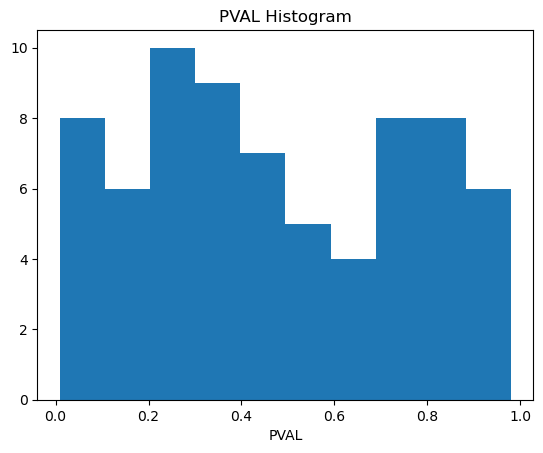

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

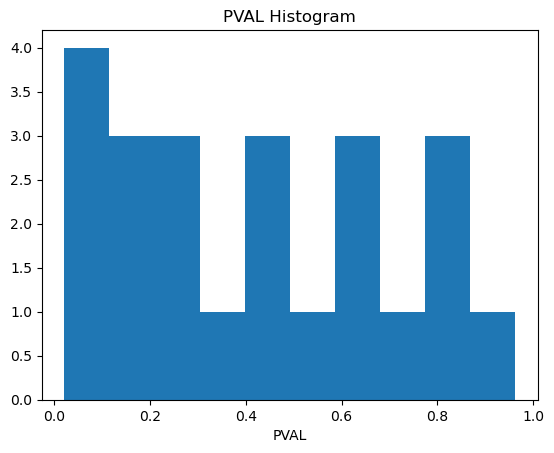

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

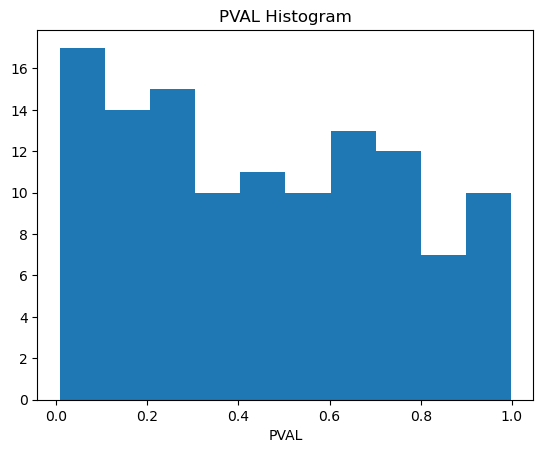

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

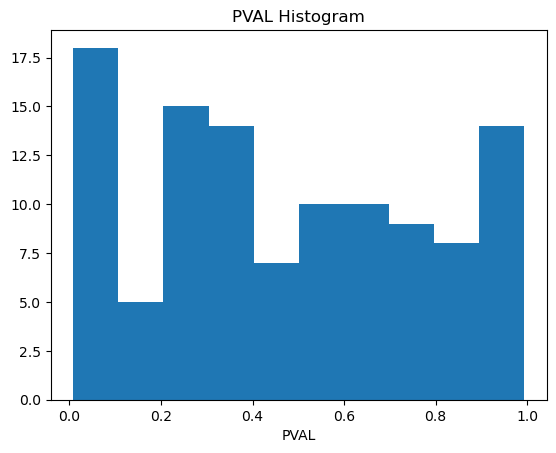

In [83]:
# make pval histogram and qval outputs
for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    output_directory = '/home/sraju/{rdir}/{p}/'.format(p=p, rdir=resdirmap[p])
    make_hla_assoc_outputs(res = res_all[p], output_directory = output_directory)

In [ ]:
# meta-analysis with METAL

In [ ]:
# outcome

In [87]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
#COLUMNCOUNTING LENIENT
OUTFILE /home/sraju/outcome_H3covar_20220315/meta_analysis_HLA .tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
WEIGHT   N
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /home/sraju/outcome_H3covar_20220315/MergeEpoch_NG_Died_vs_Survived/combined_HLAs.tsv

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
WEIGHT   N
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /home/sraju/outcome_H3covar_20220315/MergeEpoch_SL_Died_vs_Survived/combined_HLAs.tsv

ANALYZE 
"""

with open('/home/sraju/meta_outcome.cmd', 'w') as F:
    F.write(cmd)
    
!{'/home/sraju/generic-metal/metal /home/sraju/meta_outcome.cmd'}

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [ ]:
# susceptibility

In [88]:
cmd = """#LOAD THE FIRST TWO INPUT FILES

SEPARATOR TAB
VERBOSE OFF
#COLUMNCOUNTING LENIENT
OUTFILE /home/sraju/results_20220311/meta_analysis_HLA .tsv   

# === DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER   MarkerID
WEIGHT   N
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /home/sraju/results_20220311/MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl/combined_HLAs.tsv

# === THE SECOND INPUT FILE HAS THE SAME FORMAT AND CAN BE PROCESSED IMMEDIATELY ===
MARKER   MarkerID
WEIGHT   N
ALLELE   Allele1 Allele2
EFFECT   BETA
STDERR   SE
PVAL     p.value

PROCESS /home/sraju/results_20220311/MergeEpoch_SL_AgORSeqPos_Vs_PopControl/combined_HLAs.tsv

ANALYZE 
"""

with open('/home/sraju/meta_suscept.cmd', 'w') as F:
    F.write(cmd)
    
!{'/home/sraju/generic-metal/metal /home/sraju/meta_suscept.cmd'}

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis
This version released on 2011-03-25

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                

In [95]:
meta_outcome = pd.read_csv('/home/sraju/outcome_H3covar_20220315/meta_analysis_HLA1.tsv', sep = '\t')
meta_outcome['qval'] = sm.fdrcorrection(meta_outcome['P-value'], alpha = 0.05)[1]
meta_outcome.to_csv('/home/sraju/outcome_H3covar_20220315/meta_analysis_HLA1_withq.tsv', sep = '\t')

In [96]:
meta_sus = pd.read_csv('/home/sraju/results_20220311/meta_analysis_HLA1.tsv', sep = '\t')
meta_sus['qval'] = sm.fdrcorrection(meta_sus['P-value'], alpha = 0.05)[1]
meta_sus.to_csv('/home/sraju/results_20220311/meta_analysis_HLA1_withq.tsv', sep = '\t')

## Load results

In [7]:
resdirmap = {'MergeEpoch_NG_Died_vs_Survived':'outcome_H3covar_20220315',
         'MergeEpoch_SL_Died_vs_Survived':'outcome_H3covar_20220315',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl':'results_20220311',
             'MergeEpoch_SL_AgORSeqPos_Vs_PopControl':'results_20220311'}

In [43]:
res = {}
for p in ['MergeEpoch_NG_Died_vs_Survived', 'MergeEpoch_SL_Died_vs_Survived',
          'MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl', 'MergeEpoch_SL_AgORSeqPos_Vs_PopControl']:
    
    fn = 'gs://popgen-gwas/20230824_HLA/{rdir}/{p}/combined_HLAs.tsv'.format(p=p, rdir=resdirmap[p])
    res[p] = pd.read_csv(fn, sep='\t')
    res[p].index = res[p]['MarkerID']
    res[p]['OR'] = np.exp(res[p]['BETA'])
    print(p)
    display(res[p][['MarkerID', 'p.value', 'AF_case', 'AF_ctrl']].sort_values(by='p.value').head(5))
    

MergeEpoch_NG_Died_vs_Survived


,MarkerID,p.value,AF_case,AF_ctrl
MarkerID,,,,
13:01DPB1,13:01DPB1,0.009338,0.011434,0.047285
07:02B,07:02B,0.030088,0.093188,0.058160
11:01DRB1,11:01DRB1,0.032952,0.052760,0.108265
57:03B,57:03B,0.041747,0.077114,0.044965
04:01C,04:01C,0.059026,0.212629,0.283003


MergeEpoch_SL_Died_vs_Survived


,MarkerID,p.value,AF_case,AF_ctrl
MarkerID,,,,
03:19DQB1,03:19DQB1,0.021013,0.114570,0.201809
05:05DQA1,05:05DQA1,0.073178,0.149057,0.230483
53:01B,53:01B,0.080190,0.129845,0.065694
17:01C,17:01C,0.090293,0.150084,0.040762
03:01DPA1,03:01DPA1,0.136209,0.132936,0.092926


MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl


,MarkerID,p.value,AF_case,AF_ctrl
MarkerID,,,,
104:01DPB1,104:01DPB1,0.008465,0.027175,0.038900
39:10B,39:10B,0.012090,0.005909,0.010816
15:16B,15:16B,0.012384,0.032253,0.024621
14:02C,14:02C,0.025946,0.024108,0.016713
12:03C,12:03C,0.026699,0.010147,0.016972


MergeEpoch_SL_AgORSeqPos_Vs_PopControl


,MarkerID,p.value,AF_case,AF_ctrl
MarkerID,,,,
05:01DQB1,05:01DQB1,0.008330,0.183992,0.114109
07:01C,07:01C,0.011715,0.078152,0.040949
02:01DPA1,02:01DPA1,0.026820,0.505705,0.436557
02:01A,02:01A,0.041370,0.171894,0.144997
02:02DPA1,02:02DPA1,0.044274,0.213948,0.283172


In [44]:
sus_meta = pd.read_csv('gs://popgen-gwas/20230824_HLA/results_20220311/meta_analysis_HLA1_withq.tsv', sep='\t', index_col=0)
sus_meta.index = sus_meta['MarkerName']
sus_meta = sus_meta.sort_values(by='qval')
sus_meta_sig = sus_meta.loc[sus_meta['P-value']<.05, :]
sus_meta_sig

,MarkerName,Allele1,Allele2,Weight,Zscore,P-value,Direction,qval
MarkerName,,,,,,,,
15:16B,15:16B,a,g,2519.0,2.541,0.01106,++,0.586530
15:03DRB1,15:03DRB1,a,g,2519.0,2.473,0.01338,++,0.586530
39:10B,39:10B,a,g,1598.0,-2.510,0.01209,-?,0.586530
02:01DPA1,02:01DPA1,a,g,2519.0,2.373,0.01764,++,0.586530
12:03C,12:03C,a,g,1598.0,-2.216,0.02670,-?,0.591850
14:02C,14:02C,a,g,2519.0,2.281,0.02255,++,0.591850
08:06DRB1,08:06DRB1,a,g,921.0,-1.964,0.04954,?-,0.692797
01:02A,01:02A,a,g,921.0,1.977,0.04803,?+,0.692797
35:01B,35:01B,a,g,2519.0,-2.036,0.04175,--,0.692797


In [46]:
merged = pd.concat([ res['MergeEpoch_NG_ExactLVMatchqPCR2xPosOrSeqPos_Vs_PopControl'].loc[sus_meta_sig.index, ['AF_Allele2', 'OR', 'p.value']],
            res['MergeEpoch_SL_AgORSeqPos_Vs_PopControl'].loc[sus_meta_sig.index, ['AF_Allele2', 'OR', 'p.value']],
           sus_meta_sig[['P-value', 'qval']]], axis=1)


merged.columns = [('Nigeria', 'Allele Frequency'), ('Nigeria', 'Odds Ratio'), ('Nigeria', 'P-value'),
                 ('Sierra Leone', 'Allele Frequency'), ('Sierra Leone', 'Odds Ratio'), ('Sierra Leone', 'P-value'),
                 ('Meta-analysis', 'P-value'), ('Meta-analysis', 'Q-value')]

merged.columns = pd.MultiIndex.from_tuples(merged.columns)
merged.dropna()

Nigeria                          Sierra Leone             \
           Allele Frequency Odds Ratio   P-value Allele Frequency Odds Ratio   
MarkerName                                                                     
15:16B             0.026584   3.020614  0.012384         0.018076   1.776452   
15:03DRB1          0.243574   1.319887  0.089463         0.022443   2.598153   
02:01DPA1          0.354312   1.203705  0.194115         0.445717   1.451697   
14:02C             0.018615   3.215169  0.025946         0.019571   1.665962   
35:01B             0.088392   0.671095  0.107814         0.144118   0.742437   

                     Meta-analysis            
             P-value       P-value   Q-value  
MarkerName                                    
15:16B      0.364046       0.01106  0.586530  
15:03DRB1   0.063795       0.01338  0.586530  
02:01DPA1   0.026820       0.01764  0.586530  
14:02C      0.401618       0.02255  0.591850  
35:01B      0.211714       0.04175  0.692797

In [48]:
merged.loc['02:01DPA1', :]

Nigeria        Allele Frequency    0.354312
               Odds Ratio          1.203705
               P-value             0.194115
Sierra Leone   Allele Frequency    0.445717
               Odds Ratio          1.451697
               P-value             0.026820
Meta-analysis  P-value             0.017640
               Q-value             0.586530
Name: 02:01DPA1, dtype: float64

In [37]:
merged.index

Index(['15:16B', '15:03DRB1', '39:10B', '02:01DPA1', '12:03C', '14:02C',
       '08:06DRB1', '01:02A', '35:01B'],
      dtype='object', name='MarkerName')

In [38]:
merged.index = ['B*15:16', 'DRB1*15:03', 'B*39:10', 'DPA1*02:01', 'C*12:03', 'C*14:02',
       'DRB1*08:06', 'A*01:02', 'B*35:01']

In [41]:
merged

Nigeria                          Sierra Leone             \
           Allele Frequency Odds Ratio   P-value Allele Frequency Odds Ratio   
B*15:16            0.026584   1.105460  0.012384         0.018076   0.574618   
DRB1*15:03         0.243574   0.277546  0.089463         0.022443   0.954801   
B*39:10            0.009554  -1.989230  0.012090              NaN        NaN   
DPA1*02:01         0.354312   0.185404  0.194115         0.445717   0.372733   
C*12:03            0.015216  -1.349210  0.026699              NaN        NaN   
C*14:02            0.018615   1.167880  0.025946         0.019571   0.510403   
DRB1*08:06              NaN        NaN       NaN         0.022114  -1.167890   
A*01:02                 NaN        NaN       NaN         0.015443   1.344970   
B*35:01            0.088392  -0.398844  0.107814         0.144118  -0.297817   

                     Meta-analysis            
             P-value       P-value   Q-value  
B*15:16     0.364046       0.01106  0.586530  
DRB1*15:03  0.063795       0.01338  0.586530  
B*39:10          NaN       0.01209  0.586530  
DPA1*02:01  0.026820       0.01764  0.586530  
C*12:03          NaN       0.02670  0.591850  
C*14:02     0.401618       0.02255  0.591850  
DRB1*08:06  0.049540       0.04954  0.692797  
A*01:02     0.048033       0.04803  0.692797  
B*35:01     0.211714       0.04175  0.692797

In [42]:
merged.dropna()

Nigeria                          Sierra Leone             \
           Allele Frequency Odds Ratio   P-value Allele Frequency Odds Ratio   
B*15:16            0.026584   1.105460  0.012384         0.018076   0.574618   
DRB1*15:03         0.243574   0.277546  0.089463         0.022443   0.954801   
DPA1*02:01         0.354312   0.185404  0.194115         0.445717   0.372733   
C*14:02            0.018615   1.167880  0.025946         0.019571   0.510403   
B*35:01            0.088392  -0.398844  0.107814         0.144118  -0.297817   

                     Meta-analysis            
             P-value       P-value   Q-value  
B*15:16     0.364046       0.01106  0.586530  
DRB1*15:03  0.063795       0.01338  0.586530  
DPA1*02:01  0.026820       0.01764  0.586530  
C*14:02     0.401618       0.02255  0.591850  
B*35:01     0.211714       0.04175  0.692797